In [57]:
import time
from ont_fast5_api.fast5_interface import get_fast5_file
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [58]:
def loadReads(f5_file="../../similar_testdata/similar_squiggles.fast5", withMetadata=False):
    '''
        returns list of numpy arrays representing reads as well as dataframe containing reads metadata.
    '''
    print("reading squiggles file...")
    start = time.time()
    reads = []
    if withMetadata:
        ids = []
        length = []
        with get_fast5_file(f5_file, mode="r") as f5:
            for read in f5.get_reads():
                raw_data = read.get_raw_data()
                reads.append(raw_data)
                ids.append(read.read_id)
                length.append(len(raw_data))

        z = list(zip(ids, length))
        print(f"Took {time.time()-start} seconds.\n")
        return reads, pd.DataFrame(z, columns=["id", "length"])

    else:
        with get_fast5_file(f5_file, mode="r") as f5:
            for read in f5.get_reads():
                raw_data = read.get_raw_data()
                reads.append(raw_data)
        print(f"Took {time.time()-start} seconds.\n")
        return reads

In [59]:
allSquiggles, metadata = loadReads(withMetadata=True)

reading squiggles file...
Took 4.132963180541992 seconds.



The following section of code takes 2 squiggles that have a high similarity and plots them without any normalisation or cleaning of the data.

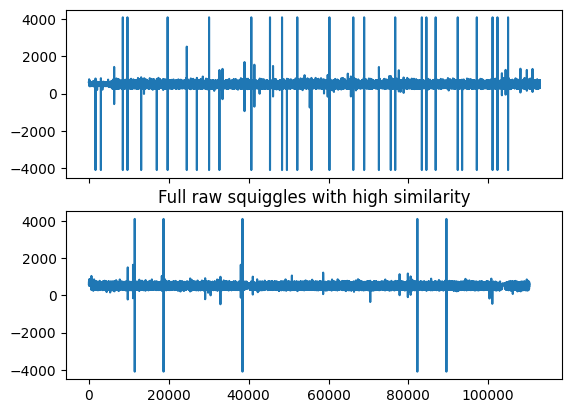

In [60]:
compNo = 2      #no. of squiggles being compared
similarSquiggles = ["995e06ac-fb8c-4c67-a783-223583c215bd", "4d1b87b0-a975-4520-bd89-40e8dd0dd185"]
similarIndices = metadata.index[(metadata['id']==similarSquiggles[0]) | (metadata['id']==similarSquiggles[1])].tolist()

copiedSquiggles = [allSquiggles[similarIndices[i]].copy() for i in range(compNo)]


fig1, axs = plt.subplots(compNo, sharex=True)
plt.title("Full raw squiggles with high similarity")
for i in range(compNo):
    axs[i].plot(copiedSquiggles[i])

plt.show()

Following section removes the spikes in the squiggles by just removing any entries with a magnitude larger than a given threshold. This is a crude method and will need to be more finely tuned.

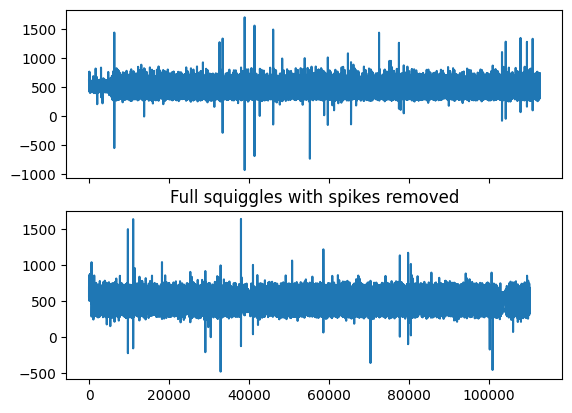

In [61]:
spikeThresh = 2000
removedSpikes = []
for i in range(compNo):
    removedSpikes.append([j for j in copiedSquiggles[i] if abs(j) < spikeThresh])

fig2, axs = plt.subplots(compNo, sharex=True)
plt.title("Full squiggles with spikes removed")
for i in range(compNo):
    axs[i].plot(removedSpikes[i])

plt.show()

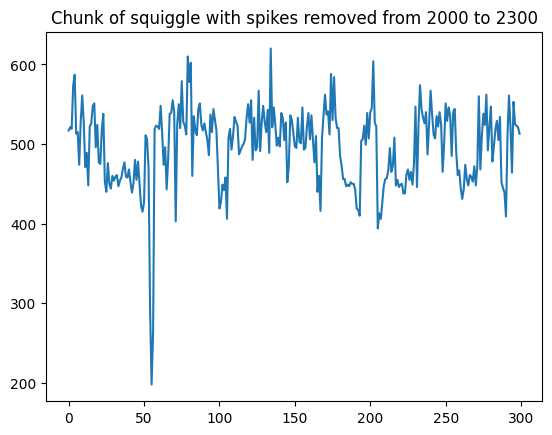

In [68]:
chunkSize = 300
startIndex = 2000
rawChunk = removedSpikes[0][startIndex:startIndex+chunkSize]

fig3 = plt.figure()
plt.title(f"Chunk of squiggle with spikes removed from {startIndex} to {startIndex+chunkSize}")

plt.plot(rawChunk)
plt.show()


The following section uses another threshold value which also requires fine tuning. The threshold value in this case is used to do a form of time normalisation wherein only datapoints with a sufficient change in current value from the previous data point are included. The following section applies the temporal normalisation to the full squiggles.

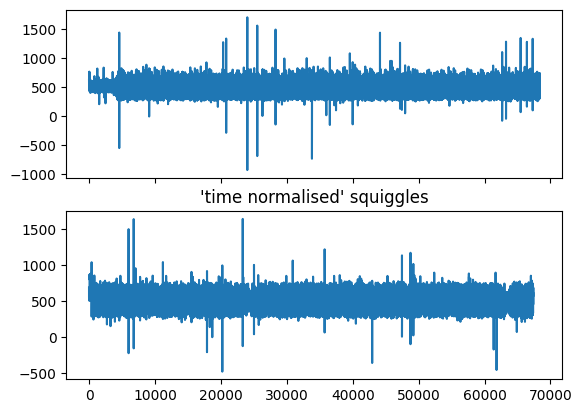

In [70]:
sequenceThresh = 10

normalisedSquiggles = []
for i in range(compNo):
    #normalisedSquiggles.append([removedSpikes[i][j] for j in range(len(removedSpikes[i]) - 1) if abs(removedSpikes[i][j] - removedSpikes[i][j+1]) > sequenceThresh])
    l = removedSpikes[i].copy()
    j = 0
    done = False
    while not done:
        while abs(l[j] - l[j+1]) < sequenceThresh and j+1 < len(l):
            l.pop(j+1)
        
        j+=1
        done = (j+1 == len(l))
    normalisedSquiggles.append(l.copy())


fig4, axs = plt.subplots(compNo, sharex=True)
plt.title("'time normalised' squiggles")
for i in range(compNo):
    axs[i].plot(normalisedSquiggles[i])

plt.show()

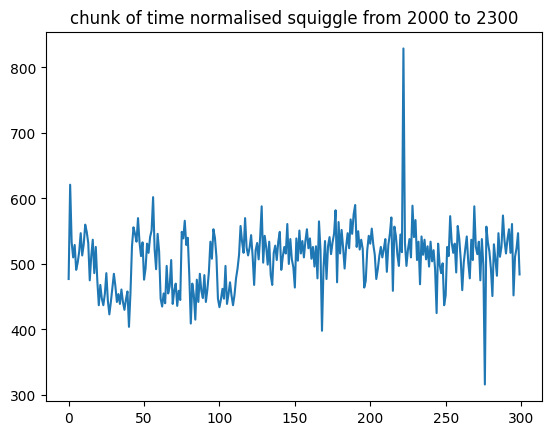

In [71]:
normalisedChunk = normalisedSquiggles[0][startIndex:startIndex+chunkSize]

fig5 = plt.figure()
plt.title(f"chunk of time normalised squiggle from {startIndex} to {startIndex+chunkSize}")

plt.plot(normalisedChunk)
plt.show()

The following section takes the normalised chunk (from squiggle 0) and performs a cross correlation with all of squiggle 1 to find where in squiggle 1 is the most similar to the normalised chunk.

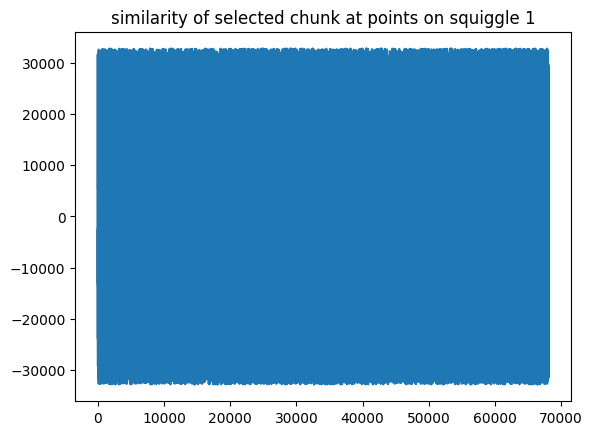

In [72]:
crossC = np.correlate(normalisedChunk, normalisedSquiggles[0])

fig6 = plt.figure()
plt.title("similarity of selected chunk at points on squiggle 1")

plt.plot(crossC)
plt.show()

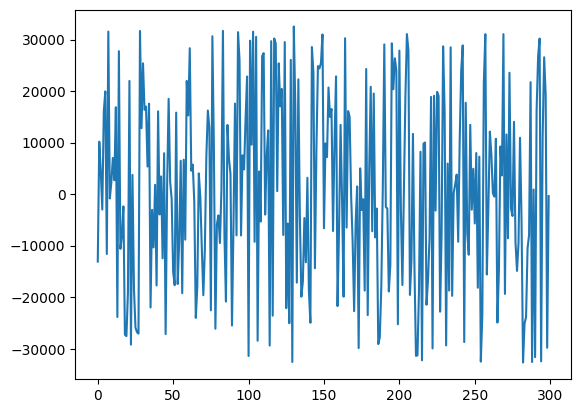

In [73]:
fig6 = plt.figure()

plt.plot(crossC[:300])
plt.show()

In [74]:
maxOverlap = np.argmax(crossC)
print(maxOverlap)

7883
